In [49]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import  tqdm

#%matplotlib inline

tqdm.pandas(tqdm)

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


In [50]:
from config_KBO import * 

In [58]:
def call_ws(addr_data): #lg = "en,fr,nl"
    t = datetime.now()
    
    params = urllib.parse.urlencode({"street": addr_data[street_field],
                                     "housenumber": addr_data[housenbr_field],
                                     "city": addr_data[city_field],
                                     "postcode": addr_data[postcode_field]
                                    })
    url = "http://172.17.0.3:5000/search/?%s"%params
    
    
    try:
        with urllib.request.urlopen(url) as response:
            res = response.read()
            res = json.loads(res)
#             print(res)
            res["time"] = datetime.now() - t
            return res
    except Exception as e:
        return str(e)
    

In [158]:
def get_plots(addresses, column):
    fig, axes = plt.subplots(ncols=1, nrows = addresses[column].nunique(),  sharex=True, figsize=[6, 3*addresses[column].nunique()])

    addresses.hist(column="_time", by=column,ax=axes)

    return fig

In [51]:
addresses = get_addresses()

/home/vandy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [98]:
display(addresses)


,addr_index,Zipcode,MunicipalityFR,StreetFR,HouseNumber,json,status,method,street,time,_time
1278223,1278223,7812,Ath,Rue du Mont(Mai),74,{'error': 'HTTPConnectionPool(host='localhost'...,error,none,,00:00:00.364517,0.364517
669747,669747,8550,Zwevegem,Blokkestraat(Z),57,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Blokkestraat,00:00:00.786517,0.786517
2034094,2034094,8980,Zonnebeke,Oude Hondstraat,8,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Oude Hondstraat,00:00:00.718302,0.718302
2384205,2384205,9990,Maldegem,Oude Aardenburgse Weg,10,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Oude Aardenburgse Weg,00:00:00.749213,0.749213
142261,142261,8510,Kortrijk,Kwabrugstraat(Bel),5,{'error': 'HTTPConnectionPool(host='localhost'...,error,none,,00:00:00.324329,0.324329
...,...,...,...,...,...,...,...,...,...,...,...
2765205,2765205,1800.0,Vilvoorde,Stationlei,1,{'match': [{'SIM_street_which': 'addr_out_stre...,match,nonum,Stationlei,00:00:01.012582,1.012582
348263,348263,1000,Bruxelles,Rue de la Presse,4,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Rue de la Presse - Drukpersstraat,00:00:00.903524,0.903524
2989443,2989443,2960,Brecht,Kraaienhorst,6,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Kraaienhorst,00:00:00.753739,0.753739
3071134,3071134,9860,Oosterzele,Bakkerstraat,20,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Bakkerstraat,00:00:00.790406,0.790406


In [100]:
with_dask = False
if with_dask : 
    dd_addresses = dd.from_pandas(addresses, npartitions=4)

    dask_task = dd_addresses.apply(call_ws, meta=('x', 'str'), axis=1)

    with ProgressBar(): 
        addresses["json"] = dask_task.compute()
else: 
    
    addresses["json"] = addresses.progress_apply(call_ws, axis=1)

In [101]:
# Flask : 1:03
# gunicorn -w 1: 0:55
# gunicorn -w 2, npartition=2: 0:30
# gunicorn -w 2, npartition=4: 0:30
# gunicorn -w 4, npartition=4: 0:33

addresses

,addr_index,Zipcode,MunicipalityFR,StreetFR,HouseNumber,json,status,method,street,time,_time
1278223,1278223,7812,Ath,Rue du Mont(Mai),74,{'error': 'HTTPConnectionPool(host='localhost'...,error,none,,00:00:00.364517,0.364517
669747,669747,8550,Zwevegem,Blokkestraat(Z),57,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Blokkestraat,00:00:00.786517,0.786517
2034094,2034094,8980,Zonnebeke,Oude Hondstraat,8,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Oude Hondstraat,00:00:00.718302,0.718302
2384205,2384205,9990,Maldegem,Oude Aardenburgse Weg,10,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Oude Aardenburgse Weg,00:00:00.749213,0.749213
142261,142261,8510,Kortrijk,Kwabrugstraat(Bel),5,{'error': 'HTTPConnectionPool(host='localhost'...,error,none,,00:00:00.324329,0.324329
...,...,...,...,...,...,...,...,...,...,...,...
2765205,2765205,1800.0,Vilvoorde,Stationlei,1,{'match': [{'SIM_street_which': 'addr_out_stre...,match,nonum,Stationlei,00:00:01.012582,1.012582
348263,348263,1000,Bruxelles,Rue de la Presse,4,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Rue de la Presse - Drukpersstraat,00:00:00.903524,0.903524
2989443,2989443,2960,Brecht,Kraaienhorst,6,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Kraaienhorst,00:00:00.753739,0.753739
3071134,3071134,9860,Oosterzele,Bakkerstraat,20,{'match': [{'SIM_street_which': 'addr_out_stre...,match,orig,Bakkerstraat,00:00:00.790406,0.790406


In [102]:
addresses["status"]= addresses.json.apply(lambda d: "error" if "error" in d else "match" if "match" in d else "rejected")
addresses["time"]  = addresses.json.apply(lambda d: d["time"])

addresses["timing"]  = addresses.json.apply(lambda d: d["timing" if "timing" in d else {}])

addresses["method"]= addresses.json.apply(lambda d: d["match"][0]["method"] if len(d)>0 and "match" in d else "none")
addresses["street"]= addresses.json.apply(lambda d: d["match"][0]["addr_out_street"] if len(d)>0 and "match" in d else "")


display(addresses.drop("json", axis=1))

,addr_index,Zipcode,MunicipalityFR,StreetFR,HouseNumber,status,method,street,time,_time
1278223,1278223,7812,Ath,Rue du Mont(Mai),74,error,none,,00:00:00.380352,0.364517
669747,669747,8550,Zwevegem,Blokkestraat(Z),57,match,orig,Blokkestraat,00:00:00.800699,0.786517
2034094,2034094,8980,Zonnebeke,Oude Hondstraat,8,match,orig,Oude Hondstraat,00:00:00.681642,0.718302
2384205,2384205,9990,Maldegem,Oude Aardenburgse Weg,10,match,orig,Oude Aardenburgse Weg,00:00:00.732109,0.749213
142261,142261,8510,Kortrijk,Kwabrugstraat(Bel),5,error,none,,00:00:00.334254,0.324329
...,...,...,...,...,...,...,...,...,...,...
2765205,2765205,1800.0,Vilvoorde,Stationlei,1,match,nonum,Stationlei,00:00:00.853862,1.012582
348263,348263,1000,Bruxelles,Rue de la Presse,4,match,orig,Rue de la Presse - Drukpersstraat,00:00:00.830837,0.903524
2989443,2989443,2960,Brecht,Kraaienhorst,6,match,orig,Kraaienhorst,00:00:00.650633,0.753739
3071134,3071134,9860,Oosterzele,Bakkerstraat,20,match,orig,Bakkerstraat,00:00:00.773442,0.790406


In [ ]:
addresses["timing"].apply(pd.Series)

In [103]:
display(addresses.status.value_counts())

match    81
error    19
Name: status, dtype: int64

In [104]:
display(addresses.method.value_counts())

orig     73
none     19
nonum     8
Name: method, dtype: int64

In [163]:
addresses["_time"] = addresses.time.apply(lambda t: t.total_seconds())



In [ ]:
print("Method : mean")

In [166]:
display(addresses.groupby("method")._time.mean())

method
none     0.351192
nonum    1.022264
orig     0.847274
Name: _time, dtype: float64

In [ ]:
print("Method : std")

In [171]:
display(addresses.groupby("method")._time.std())

method
none     0.043000
nonum    0.165834
orig     0.186315
Name: _time, dtype: float64

0.26594356101266936

In [172]:
print("Status : mean")

Status : mean


In [173]:
display(addresses.groupby("status")._time.mean())

status
error    0.351192
match    0.864557
Name: _time, dtype: float64

In [174]:
print("Status : std")

Status : std


In [175]:
display(addresses.groupby("status")._time.std())

status
error    0.043000
match    0.190809
Name: _time, dtype: float64

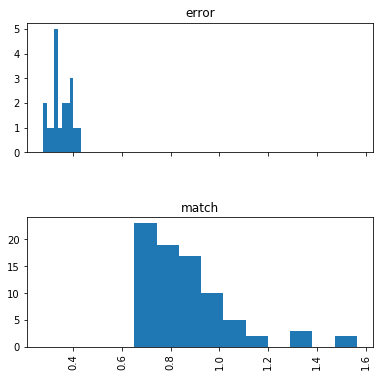

In [159]:
fig = get_plots(addresses, "status")

In [160]:
fig.savefig("time_per_status.png")

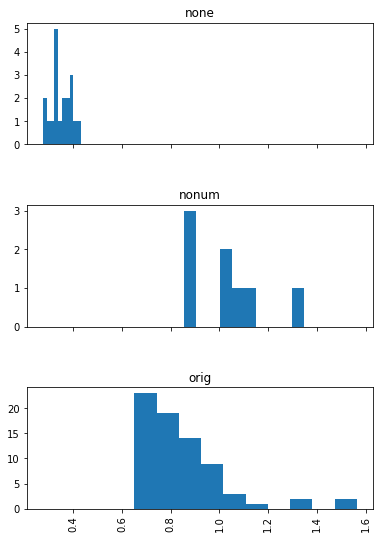

In [161]:
fig = get_plots(addresses, "method")

In [162]:
fig.savefig("time_per_method.png")